# Starter Code

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

animal_clef_2025_path = kagglehub.competition_download('animal-clef-2025')

print('Data source import complete.')


Data source import complete.


## 🐾 AnimalCLEF2025 Competition: Official Starter notebook

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

In [3]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-3o_q3toz
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-3o_q3toz
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 753d9bf64861c3e17011136b3436bf58bf02317f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/WildlifeDatasets/wildlife-tools to /tmp/pip-req-build-2huo_b9y
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-tools /tmp/pip-req-build-2huo_b9y
  Resolved https://github.com/WildlifeDatasets/wildlife-tools to commit 71aa4656d16afe4caae6d

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [4]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

We need to specify the `root`, where the data are stored and then two image transformations.
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [45]:

root = kagglehub.competition_download('animal-clef-2025')  # This returns a string path


import torchvision.transforms as T

transform_display = T.Compose([
    T.Resize([384, 384]),
])

transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


### 📊 Visualizing Data

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [6]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


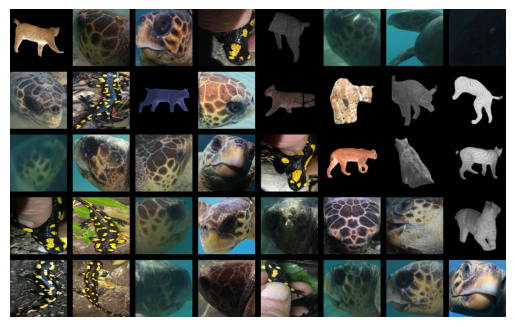

In [7]:
dataset.plot_grid()
dataset.metadata

This is confirmed by showing all datasets from which the data is composed of.

In [8]:
dataset.metadata[['dataset', 'split']].value_counts()

,,count
dataset,split,
SeaTurtleID2022,database,8729
LynxID2025,database,2957
SalamanderID2025,database,1388
LynxID2025,query,946
SalamanderID2025,query,689
SeaTurtleID2022,query,500


Now, we can plot the data of any dataset. Here we do it for the SeaTurtleID2022. The images are the same as in the query set. The goal for each image from the query set will be to determine its identity from the database (it will always be in the form `SeaTurtleID2022_t???` or to decide that it is a new individual (it is not present in the database).

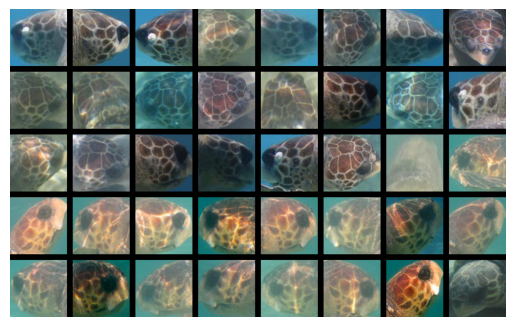

In [9]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

## Inference with MegaDescriptor

Instead of training a classifier, we can just use out of the shelf pretrained models - [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). We use MegaDescriptor to extract features from all images.

**Note:** _It is highly recommended to use the GPU acceleration._

In [10]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [11]:
#Loading the model
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)
extractor = DeepFeatures(model, device=device, batch_size=32, num_workers=0)
features_database = extractor(dataset_database)
features_query = extractor(dataset_query)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████| 67/67 [03:21<00:00,  3.00s/it]


Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

In [ ]:
similarity = CosineSimilarity()(features_query, features_database)

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

In [ ]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

In [ ]:
new_individual = 'new_individual'
threshold = 0.6
labels = dataset_database.labels_string
predictions = labels[pred_idx]
predictions[pred_scores < threshold] = new_individual
create_sample_submission(dataset_query, predictions, file_name='base_submission.csv')

# Newerer Code

In [13]:
import os, random, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm, pandas as pd
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from torch.amp import autocast, GradScaler
import kagglehub


In [ ]:

# 0) Config
root         = kagglehub.competition_download('animal-clef-2025')
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME   = 'hf-hub:BVRA/MegaDescriptor-L-384'
BATCH_SIZE   = 16
NUM_EPOCHS   = 10
LR           = 1e-5
WEIGHT_DECAY = 1e-5
TRIPLET_MARGIN = 0.5
CE_WEIGHT = 3.0    # increase emphasis on classification, weight for classification loss
TRI_WEIGHT = 1.0   # keep triplet as regularizer

# 1) Transforms & splits
transform = T.Compose([
    T.Resize([384,384]),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])
full_ds = AnimalCLEF2025(root, transform=transform, load_label=True)
db_ds   = full_ds.get_subset(full_ds.metadata['split']=='database')

# 2) Build label→index map
meta       = pd.read_csv(os.path.join(root, 'metadata.csv'))
db_meta    = meta[meta['split']=='database']
classes    = sorted(db_meta['identity'].dropna().unique())
class_to_ix = {c:i for i,c in enumerate(classes)}
ix_to_class = {i:c for c,i in class_to_ix.items()}

# 3) PyTorch Dataset for classification+triplet batching
class HybridDataset(Dataset):
    def __init__(self, base_ds, cmap):
        self.base = base_ds
        self.cmap = cmap
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img, lbl_str = self.base[idx]
        lbl = self.cmap[lbl_str]
        return img, lbl

train_ds = HybridDataset(db_ds, class_to_ix)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True
)

print(f"Loaded {len(train_ds)} train samples, batch size {BATCH_SIZE}")


In [14]:
# ── Joint CE + Triplet Training with Progressive Unfreezing ─────────

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.amp import autocast, GradScaler
import timm

In [ ]:
# Hyperparameters
MODEL_NAME     = 'hf-hub:BVRA/MegaDescriptor-L-384'
DEVICE         = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_EPOCHS     = 20
LR             = 1e-5
WEIGHT_DECAY   = 1e-5
TRIPLET_MARGIN = 0.5
CE_WEIGHT      = 1.0
TRI_WEIGHT     = 1.0
UNFREEZE_EPOCH = 6

# 4) Build backbone + head
backbone = timm.create_model(MODEL_NAME, num_classes=0, pretrained=True)
# 4.1) Freeze everything
for p in backbone.parameters():
    p.requires_grad = False
# 4.2) Unfreeze only layers.2.*
for name, p in backbone.named_parameters():
    if name.startswith("layers.2."):
        p.requires_grad = True
backbone = backbone.to(DEVICE)

head = nn.Linear(backbone.num_features, len(classes)).to(DEVICE)

# 5) Losses, optimizer, scheduler, scaler
ce_loss      = nn.CrossEntropyLoss()
triplet_loss = nn.TripletMarginLoss(margin=TRIPLET_MARGIN)

opt = optim.Adam(
    [p for p in backbone.parameters() if p.requires_grad] + list(head.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=2, verbose=True
)

scaler = GradScaler()

# 6) Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    backbone.train()
    head.train()
    running_ce = 0.0
    running_tri = 0.0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        opt.zero_grad()

        with autocast('cuda'):
            feats  = backbone(imgs)        # [B, d]
            logits = head(feats)           # [B, C]

            # 6.1) CE loss
            loss_ce = ce_loss(logits, labels)

            # 6.2) Batch-hard triplet loss
            sim = F.cosine_similarity(
                feats.unsqueeze(1), feats.unsqueeze(0), dim=2
            )
            dist = 1 - sim
            eq_mask = labels.unsqueeze(1) == labels.unsqueeze(0)
            pos_mask = eq_mask.clone()
            pos_mask.fill_diagonal_(False)
            hardest_pos = torch.where(pos_mask, dist, torch.tensor(-1e9, device=DEVICE)).max(1)[0]
            hardest_neg = torch.where(~eq_mask, dist, torch.tensor(1e9,  device=DEVICE)).min(1)[0]
            loss_tri = F.relu(hardest_pos - hardest_neg + TRIPLET_MARGIN).mean()

            # 6.3) Combined loss
            loss = CE_WEIGHT * loss_ce + TRI_WEIGHT * loss_tri

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running_ce  += loss_ce.item()  * imgs.size(0)
        running_tri += loss_tri.item() * imgs.size(0)
        total      += imgs.size(0)

    avg_ce  = running_ce / total
    avg_tri = running_tri / total
    combined = avg_ce + avg_tri

    print(f"Epoch {epoch}/{NUM_EPOCHS}  CE: {avg_ce:.4f}  Tri: {avg_tri:.4f}")

    # Step the scheduler on combined loss
    scheduler.step(combined)

    # 7) Progressive unfreeze at specified epoch
    if epoch == UNFREEZE_EPOCH:
        print(f">>> Unfreezing layers.1.* at epoch {epoch}")
        for name, p in backbone.named_parameters():
            if name.startswith("layers.1."):
                p.requires_grad = True

        # rebuild optimizer with new params at 1/10th LR
        opt = optim.Adam(
            [p for p in backbone.parameters() if p.requires_grad] + list(head.parameters()),
            lr=LR * 0.1,
            weight_decay=WEIGHT_DECAY
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='min', factor=0.5, patience=2, verbose=True
        )


Epoch 1/20  CE: 5.8967  Tri: 0.0243
Epoch 2/20  CE: 4.1082  Tri: 0.0241
Epoch 3/20  CE: 3.1747  Tri: 0.0188
Epoch 4/20  CE: 2.5511  Tri: 0.0178
Epoch 5/20  CE: 2.1064  Tri: 0.0165
Epoch 6/20  CE: 1.7769  Tri: 0.0155
>>> Unfreezing layers.1.* at epoch 6
Epoch 7/20  CE: 1.5275  Tri: 0.0151
Epoch 8/20  CE: 1.5024  Tri: 0.0153
Epoch 9/20  CE: 1.4673  Tri: 0.0137
Epoch 10/20  CE: 1.4425  Tri: 0.0119
Epoch 11/20  CE: 1.4194  Tri: 0.0148
Epoch 12/20  CE: 1.3861  Tri: 0.0140
Epoch 13/20  CE: 1.3615  Tri: 0.0141
Epoch 14/20  CE: 1.3296  Tri: 0.0140
Epoch 15/20  CE: 1.3100  Tri: 0.0134
Epoch 16/20  CE: 1.2823  Tri: 0.0147
Epoch 17/20  CE: 1.2677  Tri: 0.0127
Epoch 18/20  CE: 1.2434  Tri: 0.0121
Epoch 19/20  CE: 1.2217  Tri: 0.0131
Epoch 20/20  CE: 1.1993  Tri: 0.0135


In [ ]:
# Save both the fine‐tuned Swin weights and your classification head
torch.save({
    'backbone': backbone.state_dict(),
    'head':      head.state_dict(),
}, 'hybrid_checkpoint.pth')
print("Checkpoint saved.")


In [ ]:
# ── GPU-Accelerated Extraction & k-NN Voting Hybrid Inference & Submission ──

import torch
import timm
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from collections import Counter
from wildlife_tools.features import DeepFeatures

# 1) Clear GPU cache
torch.cuda.empty_cache()

# 2) Load your fine-tuned checkpoint
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt       = torch.load('hybrid_checkpoint.pth', map_location=DEVICE)

# 3) Rebuild backbone + head
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', num_classes=0, pretrained=False)
head     = torch.nn.Linear(backbone.num_features, len(class_to_ix))

backbone.load_state_dict(ckpt['backbone'])
head.load_state_dict(ckpt['head'])
backbone = backbone.to(DEVICE).eval().half()
head     = head.to(DEVICE).eval().half()

# 4) Extract database embeddings in tiny GPU batches
db_loader = DataLoader(
    db_ds,
    batch_size=2,     # small batch so attention fits
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

db_feats_list = []
with torch.no_grad():
    for imgs, _ in db_loader:
        imgs = imgs.to(DEVICE).half()
        with autocast(device_type='cuda'):
            feats = backbone(imgs)            # [B, D]
        db_feats_list.append(feats.cpu().float().numpy())

db_feats = np.vstack(db_feats_list)
print(f"Extracted {db_feats.shape[0]} database embeddings (dim {db_feats.shape[1]})")

# 5) k-NN Voting hyperparameters
K        = 5
conf_thr = 0.75
sim_thr  = 0.75

# 6) Build small-batch query loader
query_ds     = full_ds.get_subset(full_ds.metadata['split']=='query')
query_loader = DataLoader(
    query_ds,
    batch_size=4,   # small to avoid OOM
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 7) Loop over queries and apply hybrid: class head → k-NN voting
hybrid_preds = []

for imgs, _ in query_loader:
    imgs = imgs.to(DEVICE).half()
    with torch.no_grad(), autocast(device_type='cuda'):
        feats  = backbone(imgs)                   # [B, D]
        logits = head(feats)                      # [B, C]
        probs  = F.softmax(logits.float(), dim=1)
        conf, cls_idx = probs.max(dim=1)          # [B], [B]

    feats_np = feats.cpu().float().numpy()        # [B, D]
    sims     = cosine_similarity(feats_np, db_feats)  # [B, N_db]

    # get top-K neighbor indices and their sims
    topk_idx  = np.argsort(-sims, axis=1)[:, :K]       # [B, K]
    topk_sims = np.take_along_axis(sims, topk_idx, axis=1)  # [B, K]
    avg_sims  = topk_sims.mean(axis=1)                 # [B]

    # decide per image
    for c, ci, neigh_idxs, avg_s in zip(conf, cls_idx, topk_idx, avg_sims):
        if c >= conf_thr:
            # trust the classification head
            hybrid_preds.append(ix_to_class[int(ci)])
        elif avg_s >= sim_thr:
            # majority vote among top-K neighbors
            labels_k   = db_ds.labels_string[neigh_idxs]
            most_common = Counter(labels_k).most_common(1)[0][0]
            hybrid_preds.append(most_common)
        else:
            hybrid_preds.append('new_individual')

# 8) Write out submission
sub = pd.DataFrame({
    'image_id': query_ds.metadata['image_id'],
    'identity': hybrid_preds
})
sub.to_csv('submission_hybrid_knn.csv', index=False)
print("submission_hybrid_knn.csv ready")


Per species threshold (experimental):

In [ ]:
# ── GPU-Accelerated Extraction & k-NN Voting Hybrid Inference with Per-Species Thresholds ──

import torch
import timm
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from collections import Counter

# 1) Clear GPU cache
torch.cuda.empty_cache()

# 2) Load checkpoint
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt   = torch.load('hybrid_checkpoint.pth', map_location=DEVICE)

# 3) Rebuild backbone + head
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384',
                            num_classes=0, pretrained=False)
head = torch.nn.Linear(backbone.num_features, len(class_to_ix))
backbone.load_state_dict(ckpt['backbone'])
head.load_state_dict(ckpt['head'])
backbone = backbone.to(DEVICE).eval().half()
head     = head.to(DEVICE).eval().half()

# 4) Extract DB embeddings in small GPU batches
db_loader = DataLoader(db_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
db_feats_list = []
with torch.no_grad():
    for imgs, _ in db_loader:
        imgs = imgs.to(DEVICE).half()
        with autocast(device_type='cuda'):
            feats = backbone(imgs)
        db_feats_list.append(feats.cpu().float().numpy())
db_feats = np.vstack(db_feats_list)
print(f"Extracted {db_feats.shape[0]} database embeddings (dim {db_feats.shape[1]})")

# 5) Define per-species thresholds
# Map the 'dataset' field in metadata to (conf_threshold, sim_threshold)
species_thresholds = {
    'SeaTurtleID2022':    (0.6, 0.6),
    'SalamanderID2025':   (0.6, 0.6),
    'LynxID2025':         (0.6, 0.6),
}

# 6) Prepare query loader and species list
query_ds     = full_ds.get_subset(full_ds.metadata['split']=='query')
query_loader = DataLoader(query_ds, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
species_list = query_ds.metadata['dataset'].tolist()  # aligned order
idx_offset   = 0

hybrid_preds = []


In [ ]:
# 7) Loop over query batches
for imgs, _ in query_loader:
    batch_size = imgs.size(0)
    batch_species = species_list[idx_offset:idx_offset+batch_size]
    idx_offset += batch_size

    imgs = imgs.to(DEVICE).half()
    with torch.no_grad(), autocast(device_type='cuda'):
        feats  = backbone(imgs)                   # [B, D]
        logits = head(feats)                      # [B, C]
        probs  = F.softmax(logits.float(), dim=1)
        conf, cls_idx = probs.max(dim=1)          # [B], [B]

    feats_np = feats.cpu().float().numpy()        # [B, D]
    sims     = cosine_similarity(feats_np, db_feats)  # [B, N_db]

    # top-K voting
    K = 5
    topk_idx  = np.argsort(-sims, axis=1)[:, :K]         # [B, K]
    topk_sims = np.take_along_axis(sims, topk_idx, axis=1)  # [B, K]
    avg_sims  = topk_sims.mean(axis=1)                   # [B]

    # 8) Per-image decision
    for c, ci, neigh_idxs, avg_s, sp in zip(conf, cls_idx, topk_idx, avg_sims, batch_species):
        conf_thr, sim_thr = species_thresholds.get(sp, (0.7, 0.6))
        if c >= conf_thr:
            hybrid_preds.append(ix_to_class[int(ci)])
        elif avg_s >= sim_thr:
            labels_k = db_ds.labels_string[neigh_idxs]
            most_common = Counter(labels_k).most_common(1)[0][0]
            hybrid_preds.append(most_common)
        else:
            hybrid_preds.append('new_individual')

# 9) Write submission CSV
sub = pd.DataFrame({
    'image_id': query_ds.metadata['image_id'],
    'identity': hybrid_preds
})
sub.to_csv('submission_hybrid_knn_per_species.csv', index=False)
print("submission_hybrid_knn_per_species.csv ready!")


Linear Regression Addition on Fine Tuned Model

In [ ]:
# ── Old LR on Single-NN Distances ─────────────────────────────────────────────
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics         import f1_score
from sklearn.metrics.pairwise import cosine_similarity

# ── 0) Hyperparameters ───────────────────────────────────────────────────────
MAX_ANCHORS = 10000    # how many DB anchors to sample for LR training
THRESHOLD   = 0.9975      # probability threshold for “known” vs “new”


# ── 2) six distance‐features helper ───────────────────────────────────────────
def six_feats(a, b):
    sim      = cosine_similarity([a], [b])[0,0]
    euclid   = np.linalg.norm(a - b)
    dot      = a.dot(b)
    abs_diff = np.abs(a - b).mean()
    l1       = np.sum(np.abs(a - b))
    l2       = np.sum((a - b)**2)
    return [sim, euclid, dot, abs_diff, l1, l2]

# ── 3) Build (X, y) by sampling one positive + one negative per anchor ────────
n_db    = feat_db.shape[0]
anchors = random.sample(range(n_db), min(MAX_ANCHORS, n_db))

X, y = [], []
for i in anchors:
    a_emb = feat_db[i]
    a_lbl = labels_db[i]

    # positive example
    pos_inds = np.where(labels_db == a_lbl)[0]
    pos_inds = pos_inds[pos_inds != i]
    if len(pos_inds) == 0:
        continue
    j = random.choice(pos_inds)
    X.append(six_feats(a_emb, feat_db[j])); y.append(1)

    # negative example
    neg_inds = np.where(labels_db != a_lbl)[0]
    k = random.choice(neg_inds)
    X.append(six_feats(a_emb, feat_db[k])); y.append(0)

X = np.array(X)
y = np.array(y)
print(f"Built LR train set: {X.shape[0]} examples   (+1: {y.sum():d}, 0: {(y==0).sum():d})")

# ── 4) Scale, split & fit LR ─────────────────────────────────────────────────
scaler = StandardScaler().fit(X)
Xs     = scaler.transform(X)
Xtr, Xv, ytr, yv = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=42)

clf = LogisticRegression(
    class_weight='balanced',
    max_iter=1000
).fit(Xtr, ytr)

val_f1 = f1_score(yv, clf.predict(Xv))
print(f"Validation F1: {val_f1:.4f}")

# ── 5) Inference on query split ───────────────────────────────────────────────
preds = []
for emb in feat_q:
    # find single‐nearest neighbor in DB
    sims   = cosine_similarity([emb], feat_db)[0]
    best_i = sims.argmax()
    db_emb = feat_db[best_i]

    # build 6-feature vector for that pair
    fv     = six_feats(emb, db_emb)
    p      = clf.predict_proba([scaler.transform([fv])[0]])[0,1]

    if p >= THRESHOLD:
        preds.append(labels_db[best_i])
    else:
        preds.append('new_individual')

# ── 6) Write submission.csv ──────────────────────────────────────────────────
sub = pd.DataFrame({
    'image_id': q_ds.metadata['image_id'],
    'identity': preds
})
sub.to_csv('submission_old_lr.csv', index=False)
print("submission_old_lr.csv ready!  (threshold =", THRESHOLD, ")")


CLass Head + LR

In [ ]:
# ── Hybrid: Head for Known/Unknown → LR on Single‐NN Distances ───────────────
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics         import f1_score
from sklearn.metrics.pairwise import cosine_similarity

# ── 0) Hyperparameters ───────────────────────────────────────────────────────
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME  = 'hf-hub:BVRA/MegaDescriptor-L-384'
MAX_ANCHORS = 10000     # how many DB anchors to sample for LR training
HEAD_THR    = 0.3       # head confidence threshold for “known”
LR_THR      = 0.9975    # LR probability threshold for “match” among known

# ── 1) Rebuild class_to_ix from your database split ─────────────────────────
#    (so head’s output size matches)
classes       = sorted(set(db_ds.labels_string))
class_to_ix   = {c:i for i,c in enumerate(classes)}
ix_to_class   = {i:c for c,i in class_to_ix.items()}

# ── 2) Reload your fine-tuned backbone + head ───────────────────────────────
ckpt = torch.load('hybrid_checkpoint.pth', map_location=DEVICE)

backbone = timm.create_model(MODEL_NAME, num_classes=0, pretrained=False)
head     = nn.Linear(backbone.num_features, len(class_to_ix))

backbone.load_state_dict(ckpt['backbone'])
head.load_state_dict(ckpt['head'])

backbone = backbone.to(DEVICE).eval()
head     = head.to(DEVICE).eval()

# ── 3) six distance-features helper ─────────────────────────────────────────
def six_feats(a, b):
    sim      = cosine_similarity([a], [b])[0,0]
    euclid   = np.linalg.norm(a - b)
    dot      = a.dot(b)
    abs_diff = np.abs(a - b).mean()
    l1       = np.sum(np.abs(a - b))
    l2       = np.sum((a - b)**2)
    return [sim, euclid, dot, abs_diff, l1, l2]

# ── 4) Train LR on one‐positive + one‐negative per anchor ────────────────────
n_db    = feat_db.shape[0]
anchors = random.sample(range(n_db), min(MAX_ANCHORS, n_db))

X, y = [], []
for i in anchors:
    a_emb = feat_db[i]; a_lbl = labels_db[i]

    # positive
    pos_inds = np.where(labels_db == a_lbl)[0]
    pos_inds = pos_inds[pos_inds != i]
    if len(pos_inds):
        j = random.choice(pos_inds)
        X.append(six_feats(a_emb, feat_db[j])); y.append(1)

    # negative
    neg_inds = np.where(labels_db != a_lbl)[0]
    if len(neg_inds):
        k = random.choice(neg_inds)
        X.append(six_feats(a_emb, feat_db[k])); y.append(0)

X = np.array(X); y = np.array(y)
print(f"Built LR train set: {X.shape[0]} examples   (+1: {y.sum():d}, 0: {(y==0).sum():d})")

scaler = StandardScaler().fit(X)
Xs     = scaler.transform(X)
Xtr, Xv, ytr, yv = train_test_split(Xs, y, stratify=y, test_size=0.2, random_state=42)

clf = LogisticRegression(class_weight='balanced', max_iter=1000).fit(Xtr, ytr)
val_f1 = f1_score(yv, clf.predict(Xv))
print(f"Validation F1 (LR): {val_f1:.4f}")

# ── 5) Hybrid inference on query split ───────────────────────────────────────
preds = []
ql = DataLoader(q_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

with torch.no_grad():
    for imgs, _ in ql:
        imgs   = imgs.to(DEVICE)
        feats  = backbone(imgs)              # [B, d]
        logits = head(feats)                 # [B, C]
        probs  = F.softmax(logits, dim=1)    # [B, C]
        conf, _ = probs.max(dim=1)           # [B]
        feats_np = feats.cpu().numpy()       # [B, d]

        for c, emb in zip(conf, feats_np):
            if c < HEAD_THR:
                preds.append('new_individual')
            else:
                sims   = cosine_similarity([emb], feat_db)[0]
                best_i = sims.argmax()
                db_emb = feat_db[best_i]

                fv = six_feats(emb, db_emb)
                p  = clf.predict_proba([scaler.transform([fv])[0]])[0,1]
                if p >= LR_THR:
                    preds.append(labels_db[best_i])
                else:
                    preds.append('new_individual')

# ── 6) Write submission ─────────────────────────────────────────────────────
sub = pd.DataFrame({
    'image_id': q_ds.metadata['image_id'],
    'identity': preds
})
sub.to_csv('submission_hybrid_head_lr.csv', index=False)
print("submission_hybrid_head_lr.csv ready!")
